# Example 3 - Amplifier with end reflection

A fiber amplifier with free-space output must be protected from backreflections by using an isolator or angle-cleaving the output fiber facet. In this example, we investigate what happens if the fiber end is not cleaved and we get 4 % Fresnel backreflection to the amplifier. Even though we are modeling a steady-state situation, we will use the dynamic simulation algorithm to apply the reflective boundary condition. We will use a "trick" to greatly speed up the simulation compared to a normal time-dynamic simulation.

### Imports

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from pyfiberamp.dynamic import DynamicSimulation
from pyfiberamp.steady_state import SteadyStateSimulation
from pyfiberamp.fibers import YbDopedFiber

### 1) Creating the fiber (1.5 m long, 6 um core, single-clad)

In [2]:
fiber_length = 1.5
core_radius = 3e-6
core_na = 0.12
yb_number_density = 1e25
background_loss = 0 

yb_fiber = YbDopedFiber(length=fiber_length,
                        core_radius=core_radius,
                        core_na=core_na,
                        ion_number_density=yb_number_density,
                        background_loss=background_loss)

### 2) Setting the other simulation parameters

We are using a wavelength-stabilized 600 mW diode at 976 nm as our pump source. The input signal power is 100 mW at 1030 nm. The reflectance at the end facet without an angle cleave is approx. 4 % = 0.04 in absolute units.

The number of spatial nodes in the simulation grid is set to 150 (1 node/cm) which is adequate for these gain and absorption values. You can check this by running the simulation with more nodes. For example, using ten times the current number of nodes only changes the signal powers by a few hundred microwatts.

The number of time steps is set to 300000. This is not a critical parameter here because we are interested only in the steady state and not in how it is reached. See *Section 4* below for details.

In [3]:
pump_wavelength = 976e-9
pump_power = 0.6

signal_wavelength = 1030e-9   
signal_power = 0.05

end_reflectance_without_angle = 0.04

spatial_nodes = 180
time_steps = 300000

### 3) Setting up the simulation with end reflection

As already mentioned, we are using the **DynamicSimulation** interface which allows reflective boundary conditions. We add the fiber, the pump channel and two channels for the amplified signal: one forward and one backward propagating. See *Example 2* on relaxation oscillations for more details on seting the reflective boundary conditions. The current situation is actually simpler than the laser modeled in *Example 2* since we only have one reflection from the output end of the amplifier. The input power of the backward channel is set to zero so its only input is the reflection from the forward channel.

In [4]:
simulation = DynamicSimulation(max_time_steps=time_steps, fiber=yb_fiber)
simulation.add_forward_pump(wl=pump_wavelength, input_power=pump_power)
simulation.add_forward_signal(wl=signal_wavelength,
                              input_power=signal_power, 
                              channel_id='amplified_signal',
                              reflection_target_id='backreflection',
                              reflectance=end_reflectance_without_angle)
simulation.add_backward_signal(wl=signal_wavelength,
                               input_power=0.0,
                               channel_id='backreflection')

### 4) Running the simulation

This is where we apply the "trick" to make the simulation converge faster. We are not interested in how the excitation builds up in the amplifier so we can use a time step several orders of magnitude larger than the physically correct value. The realistic time step as defined by the Courant condition in this case would be roughly 50 ps. You can check this yourself using the "dynamic_time_coordinates" function from helper_funcs, see *Example 1, Section 3*, or by running the simulation with default parameters and checking the time resolution of the result.

Here we set the time step to 100 ns which is multiple orders of magnitude larger but the simulation still converges to the correct steady state. Too large a value would prevent convergence but a good value is easy to find by trial and error.

We also set the "stop_at_steady_state" flag as True to make the simulation stop as soon as the steady state is reached. 

In [5]:
result = simulation.run(spatial_nodes, dt=1e-7, stop_at_steady_state=True)

### 5 ) Plotting the steady state

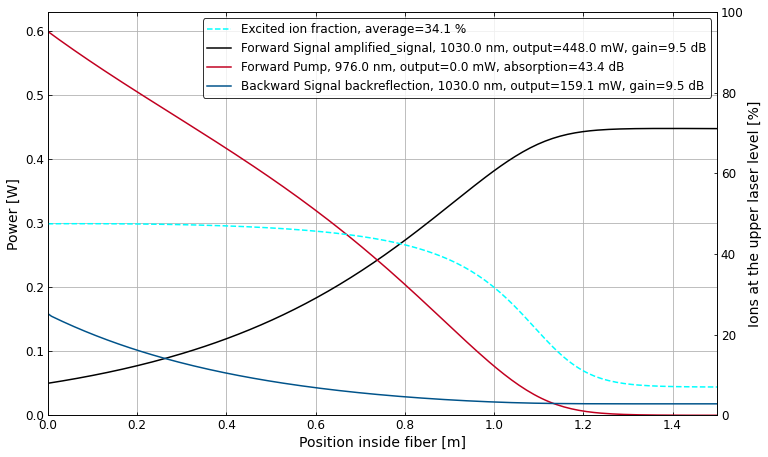

In [6]:
result.plot_power_evolution()

Unsurprisingly, the backward signal extracts a significant fraction of the energy available in the fiber amplifier, robbing gain from the forward signal. Both the forward and backward signals experience the same gain.

The problem would be even worse in a high-gain amplifier. In dB scale, the 4 % end reflection is roughly 14 dB so, in an amplifier with 14 dB gain, the reflected signal at the output end would be equal to the actual input signal and take an equal fraction of the available power. If the amplifier gain would be higher than 14 dB, the backreflected signal would be stronger than the actual forward-propagating signal.

### 6) Setting up and running a simulation without end reflection

Because of the power loss and the possibility of burning a component because of the significant backward-propagating power, we decide to make an angle cleave to remove the end reflection. Let's see how much better the amplifier would work.

Strictly speaking, we no longer need the **DynamicSimulation** interface because we have only transmissive boundary conditions. Still, we will keep using **DynamicSimulation** to make the difference to the previous simulation more apparent. The only difference is, in fact, that the backward channel has been removed along with the labeling of the channels. Alternatively, we could have kept the backward channel but set the reflectance to zero. However, removing unnecessary channels is a good practice since it makes the computation more efficient.

In [7]:
simulation_improved = DynamicSimulation(max_time_steps=time_steps, fiber=yb_fiber)
simulation_improved.add_forward_pump(wl=pump_wavelength, input_power=pump_power)
simulation_improved.add_forward_signal(wl=signal_wavelength,
                              input_power=signal_power)
result_improved = simulation_improved.run(spatial_nodes, dt=1e-7, stop_at_steady_state=True)

### 7) Plotting the improved steady state

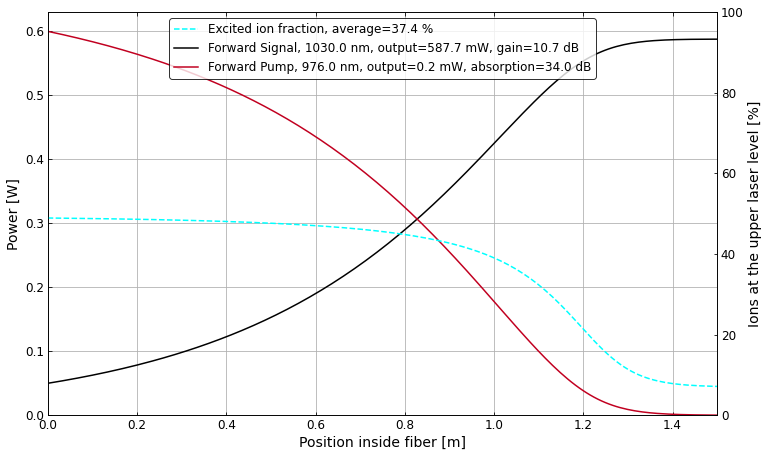

In [8]:
result_improved.plot_power_evolution()

The pump is still totally absorbed but this time all the power goes to the forward signal beam which is ~140 mW stronger than in the first simulation. The average excitation in the fiber is slightly higher in this simulation, resulting in larger losses to spontaneous emission (the total output power of the two signals in the first example is a little bit higher than the forward signal output power in this example).

ASE was not simulated to keep this example cleaner.

## 8) New in version 0.5: Steady-state simulation also supports end reflections
We can run the simulation with back reflection using the steady-state model too and compare results.

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          8.39e-04       1.39e-17          20             31       
       2          4.24e-05       0.00e+00          51             59       
       3          1.58e-06       3.47e-18          110            84       
       4          2.18e-07       3.47e-18          194            50       
       5          9.93e-08       3.47e-18          244             0       
Solved in 5 iterations, number of nodes 244. 
Maximum relative residual: 9.93e-08 
Maximum boundary residual: 3.47e-18


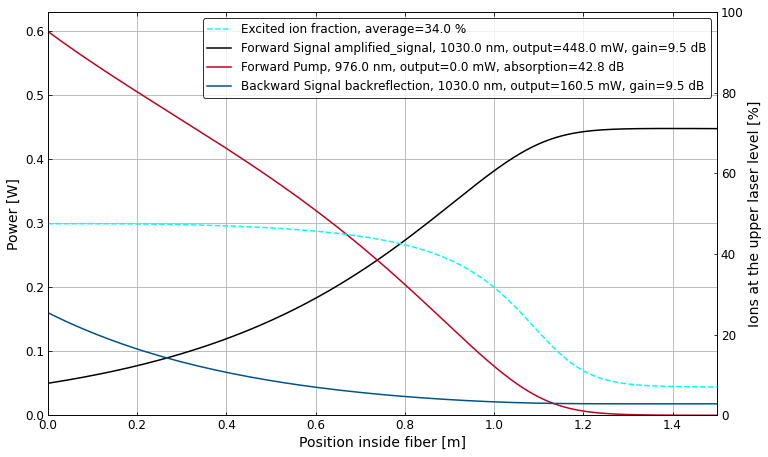

In [9]:
simulation = SteadyStateSimulation(fiber=yb_fiber)
simulation.add_forward_pump(wl=pump_wavelength, input_power=pump_power)
simulation.add_forward_signal(wl=signal_wavelength,
                              input_power=signal_power, 
                              channel_id='amplified_signal',
                              reflection_target_id='backreflection',
                              reflectance=end_reflectance_without_angle)
simulation.add_backward_signal(wl=signal_wavelength,
                               input_power=0.0,
                               channel_id='backreflection')
ss_result = simulation.run(tol=1e-7)
ss_result.plot_power_evolution()

We can note that the result agrees very well with the dynamic algorithm's output, for example the output power is exactly the same.

If you want to ask a question or send feedback about this example, please open a new issue on GitHub or contact me at <pyfiberamp@gmail.com>.